In [1]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
# use %matplotlib notebook for interactive plots here in the notebook
from igor.binarywave import Waves

In [2]:
import lmfit
from lmfit import Model
import pickle

In [3]:
e=1.60217646e-19;  mstar=8.724125937209915e-32; h=6.626068e-34; G_0=7.45e-5; hbar=h/2.0/np.pi;
# D=5.106250385935459e-03 # diffusion constant

from scipy.special import psi

# basic fit function
def wlcorr(b, bo, ro, Bphi, Bi, Bstar, lin, A):
    """ Weak localization peak fitting function. Adapted from Igor code. """
    b=b-bo

    z1=np.array(abs(b)/abs(Bphi), dtype=np.float64)
    F1=np.log(z1)+psi(0.5+1/z1)

    z2=np.array(abs(b)/(abs(Bphi)+2*abs(Bi)), dtype=np.float64)
    F2=np.log(z2)+psi(0.5+1/z2)

    z3=np.array(abs(b)/(abs(Bphi)+abs(Bstar)), dtype=np.float64)
    F3=np.log(z3)+psi(0.5+1/z3)

    return (lin*b) + ro - A*ro**2.0*(e*e/np.pi/h*(F1-F2-2*F3))
# unit of Bphi is determined by unit of denominator--abs(b) or similar, if the b input is in mT, then, Bphi in mT, if the B input is in T, then, Bphi in T

def wlcorrd(b,  Bphi, Bi, Bstar,bo, c1,c2):
    """ Weak localization peak fitting function. Adapted from Igor code. """
    

    z1=np.array(abs(b-bo)/1000/abs(Bphi), dtype=np.float64)
    F1=np.log(z1)+psi(0.5+1/z1)

    z2=np.array(abs(b-bo)/1000/(abs(Bphi)+2*abs(Bi)), dtype=np.float64)
    F2=np.log(z2)+psi(0.5+1/z2)

    z3=np.array(abs(b-bo)/1000/(abs(Bphi)+abs(Bstar)), dtype=np.float64)
    F3=np.log(z3)+psi(0.5+1/z3)

    return c1*(b-bo) + c2 - (e*e/np.pi/h*(F1-F2-2*F3))
# unit of Bphi is determined by unit of denominator---abs(b-bo)/1000, for input b in mT (thus bo also in mT), abs(b-bo)/1000 is in T, thus Bphi in T


###########
#function mgrapheneWLd(b,bphi,bi,bs,b0,c1,c2)
#     variable b,bphi,bi,bs,b0,c1,c2
#     variable t1 = ffunc((b-b0)/1000/abs(bphi))
#     variable t2 = ffunc((b-b0)/1000/(abs(bphi)+2*abs(bi)))
#     variable t3 = ffunc((b-b0)/1000/(abs(bphi)+abs(bs))) 
#     return -(t1 - t2 - 2*t3)*3.87e-5/pi+c1*(b-b0)+c2
#end
###########
#       K0     =0.0010882 ± 1.06e-005
#       K1     =-0.0012604 ± 1.63e-005
#       K2     =-0.030482 ± 0.00019
#       K3     =3.3877 ± 0.0215
#       K4     =9.5847e-009 ± 1.23e-010
#       K5     =-1.9421e-007 ± 3.52e-008

### parabola to fit curvature only ###
def parabola(b, bo, ro, a):
    """ Inverse parabola for fitting  """
    return ro - a*np.power(b - bo, 2)


def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx


def round_to(n, precision):
    """ http://stackoverflow.com/questions/4265546/python-round-to-nearest-05 """
    correction = 0.5 if n >= 0 else -0.5
    return int( n/precision+correction ) * precision


def wl_fit(b, rxx, width, height, fix = None, ro=None, bcenter = None):
    """ fit a single b_perpendicular (b) and r_xx set to the WL model.
    
        Inputs:  width -- range of data over which to fit
                 fix -- dictionary of parameters to fix and their values
                 ro -- initial guess at ro
                 bcenter -- initial guess at bcenter 
        Outputs: results -- lmfit results object """

    # create model
    model = Model(wlcorr, independent_vars=['b'])
    params = model.make_params()
    method = 'nelder'

    if not bcenter:
        bcenter = b.mean()
    if not ro:
        ro = rxx[find_nearest(b, bcenter)]
    
    ### data selection criteria ###
    right = bcenter+width
    left = bcenter-width 
    bottom = (1-height)*ro

    bi = (b > left) & (b < right)
    ri = (rxx > bottom)
    inds = bi & ri

    b = b[inds]
    rxx = rxx[inds]
    ### end data selection ###

    # always vary
    params['bo'].value = bcenter
    params['ro'].value = round_to(ro, 0.5)
    params['Bphi'].value = 0.15

    # sometimes vary
    params['Bi'].value = 1.8
    params['Bstar'].value = 2.5e7
    params['lin'].value = 0.0027
    params['A'].value = 1.00 
        
    if fix:
        for p in fix:
            params[p].vary = False
            params[p].value = fix[p]

    result = model.fit(rxx, params, b=b, method = method)
    return result

In [4]:
local_data = 'Y:/qdot25/Rui/161012'

In [5]:
import os, shutil

In [6]:
os.chdir(local_data)

# dat3g4x

In [7]:
w = Waves('dat3g4x.ibw') 

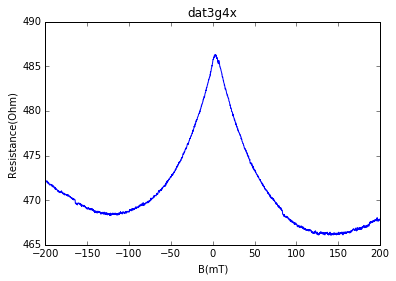

In [11]:
fig, ax = plt.subplots(1,1)
ax.plot(w.x, (1)*w.y/1000/600e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat3g4x')

In [13]:
from IPython.display import Image, display

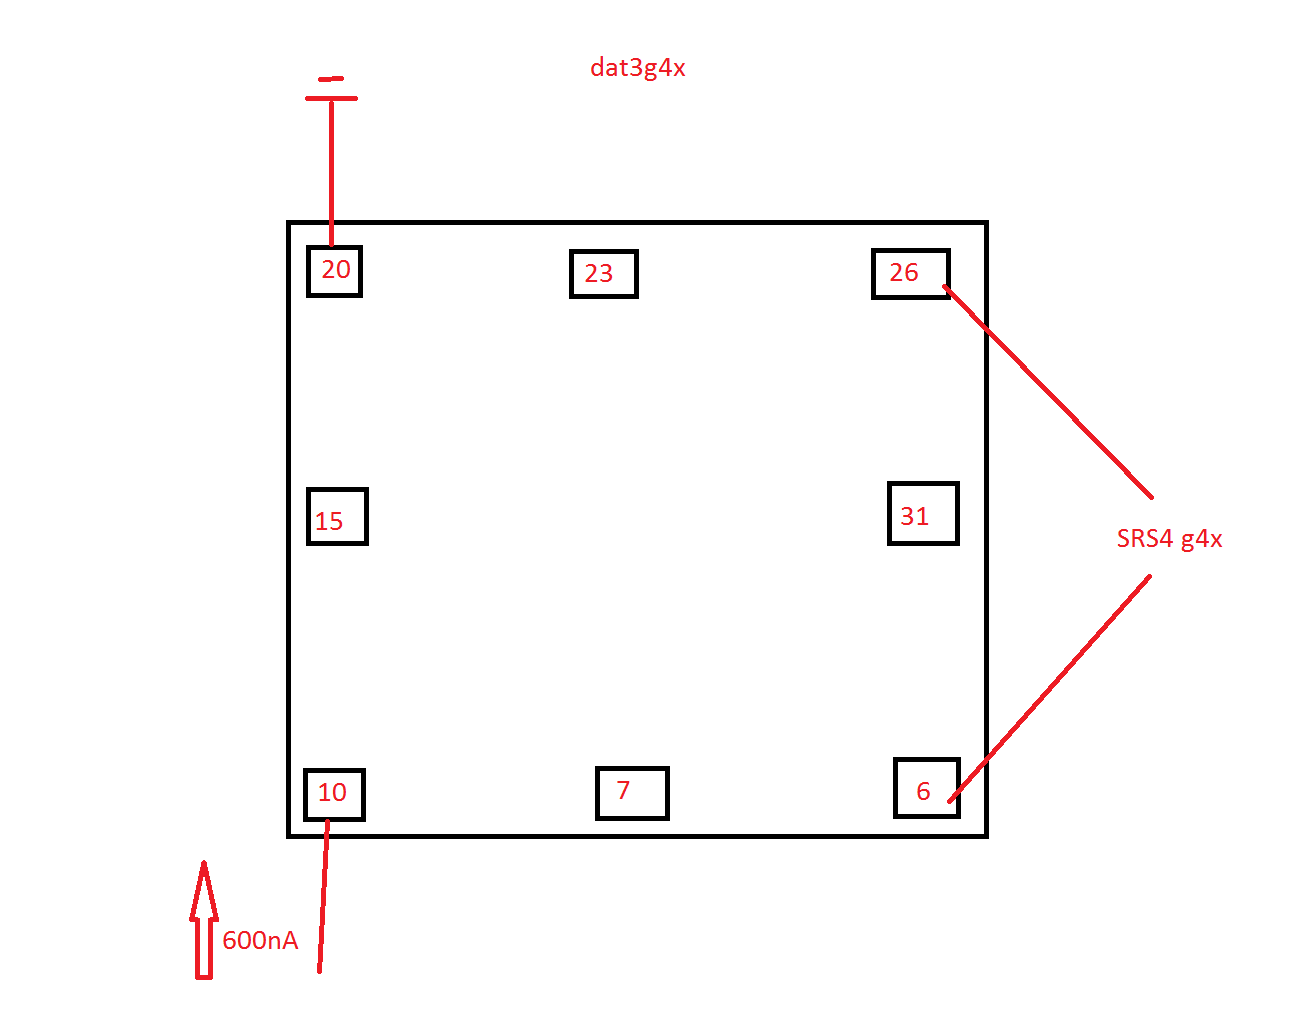

In [38]:
fig_dat3g4x = 'C:/Users/labuser/Desktop'
display(Image(filename=os.path.join(fig_dat3g4x,'configdat3g4x.png')))

# dat6g4x

In [18]:
w2 = Waves('dat6g4x.ibw') 

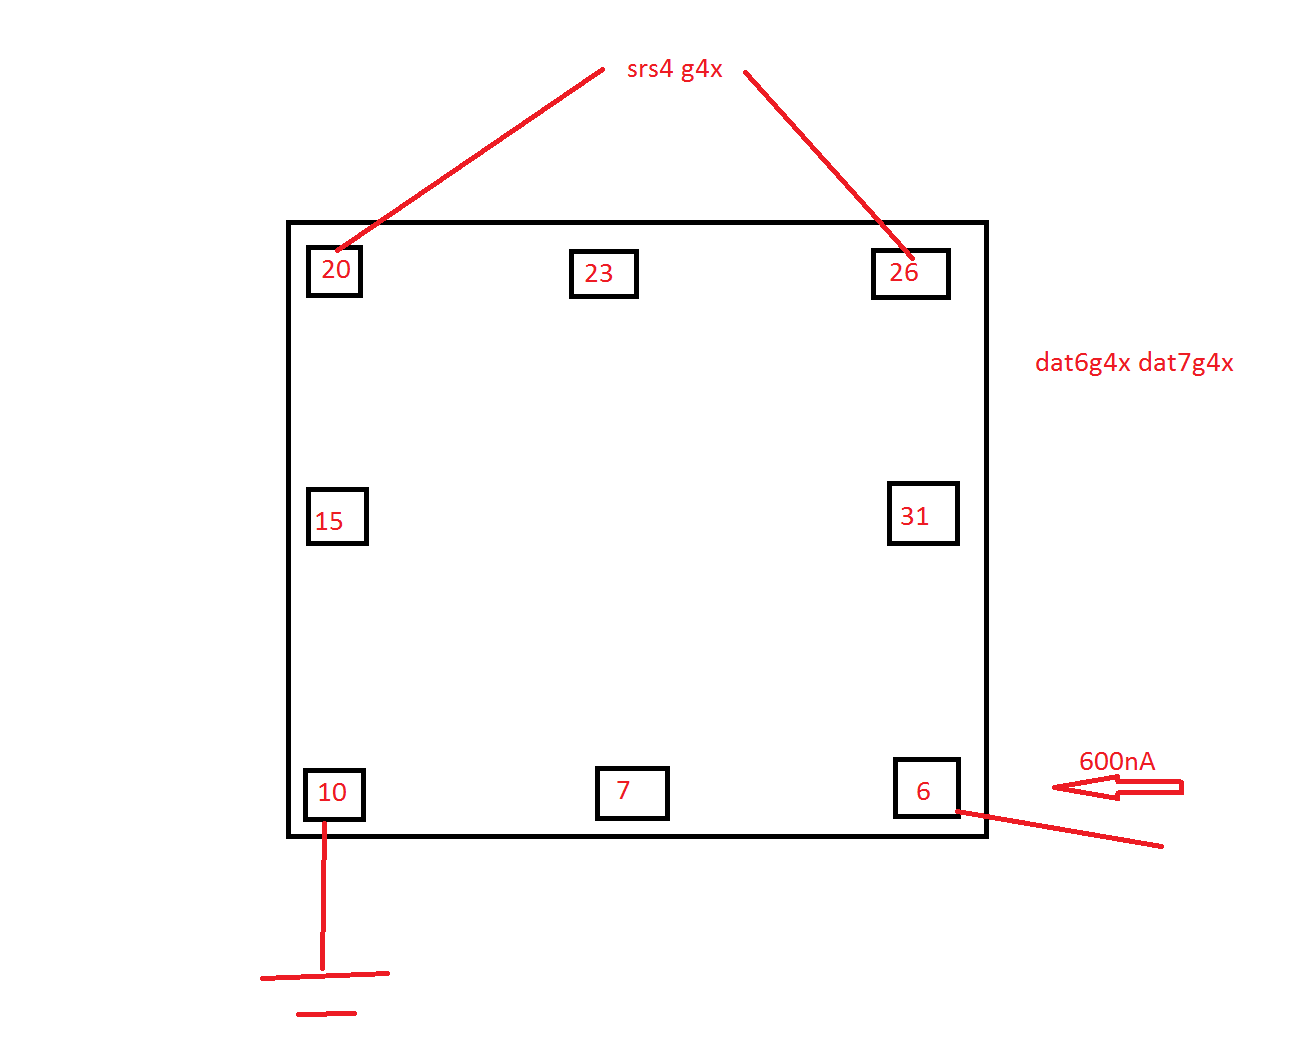

In [35]:
fig_dat6g4x = 'C:/Users/labuser/Desktop'
display(Image(filename=os.path.join(fig_dat3g4x,'configdat6g4x.png')))

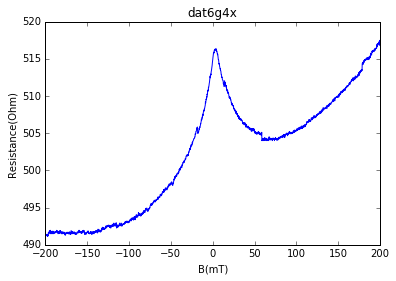

In [20]:
fig, ax = plt.subplots(1,1)
ax.plot(w2.x, (1)*w2.y/1000/600e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat6g4x')

# dat8g4x

In [21]:
w3 = Waves('dat8g4x.ibw') 

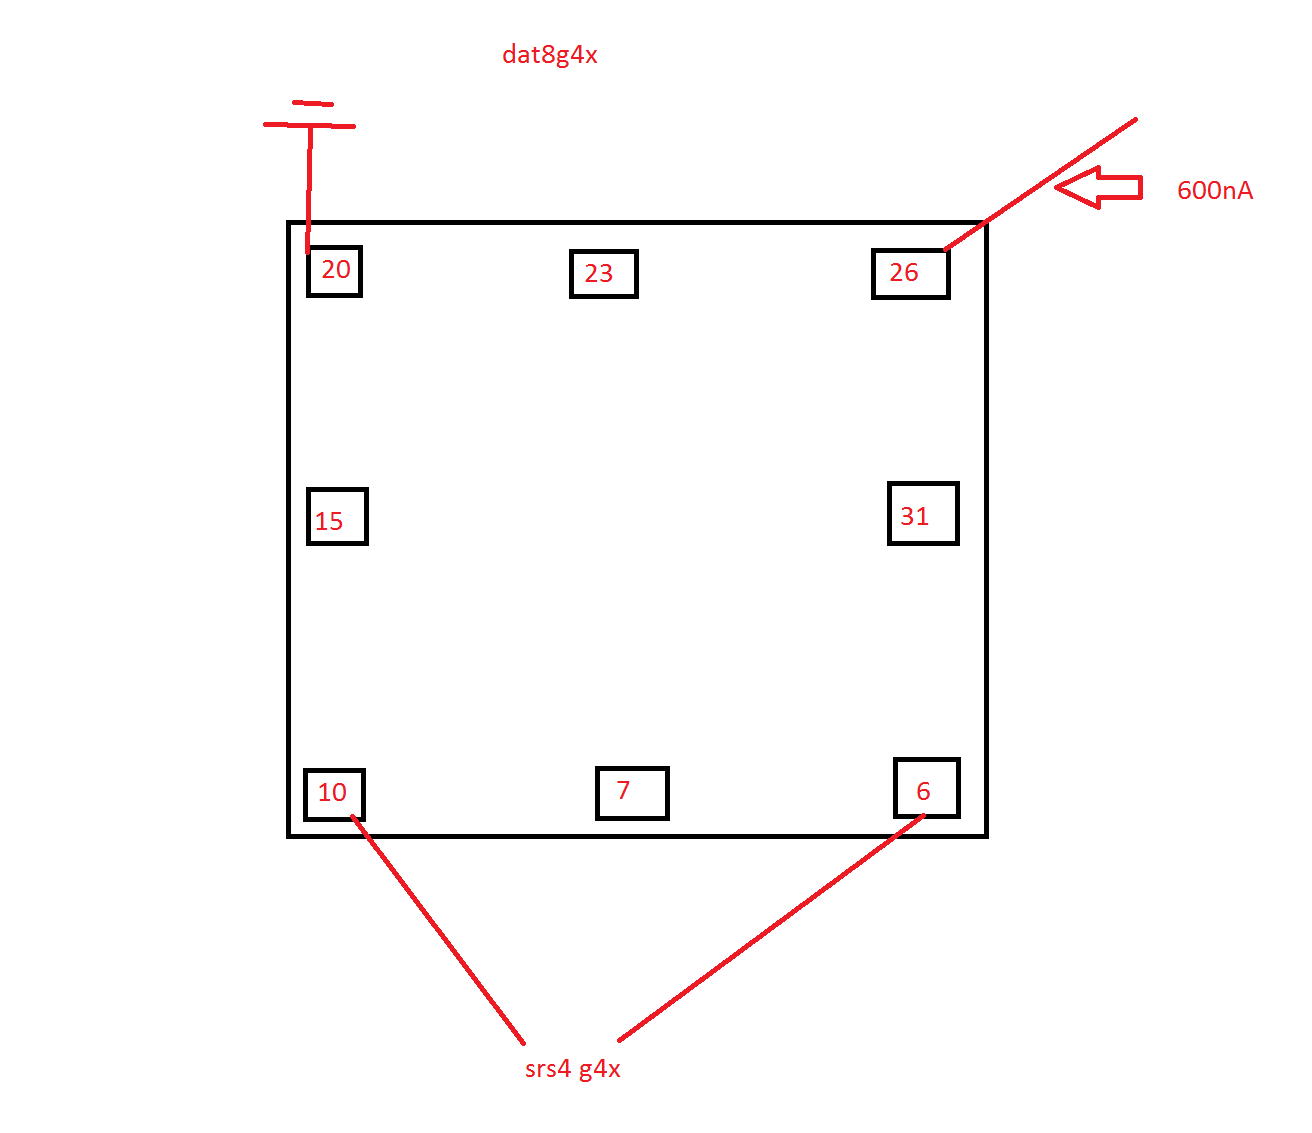

In [36]:
fig_dat8g4x = 'C:/Users/labuser/Desktop'
display(Image(filename=os.path.join(fig_dat8g4x,'configdat8g4x.png')))

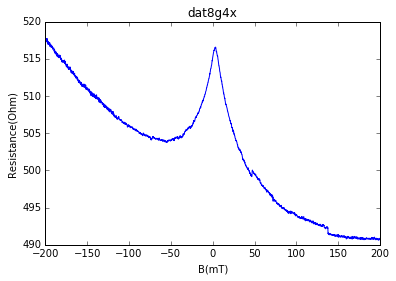

In [23]:
fig, ax = plt.subplots(1,1)
ax.plot(w3.x, (1)*w3.y/1000/600e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat8g4x')

# dat10g4x

In [24]:
w4 = Waves('dat10g4x.ibw') 

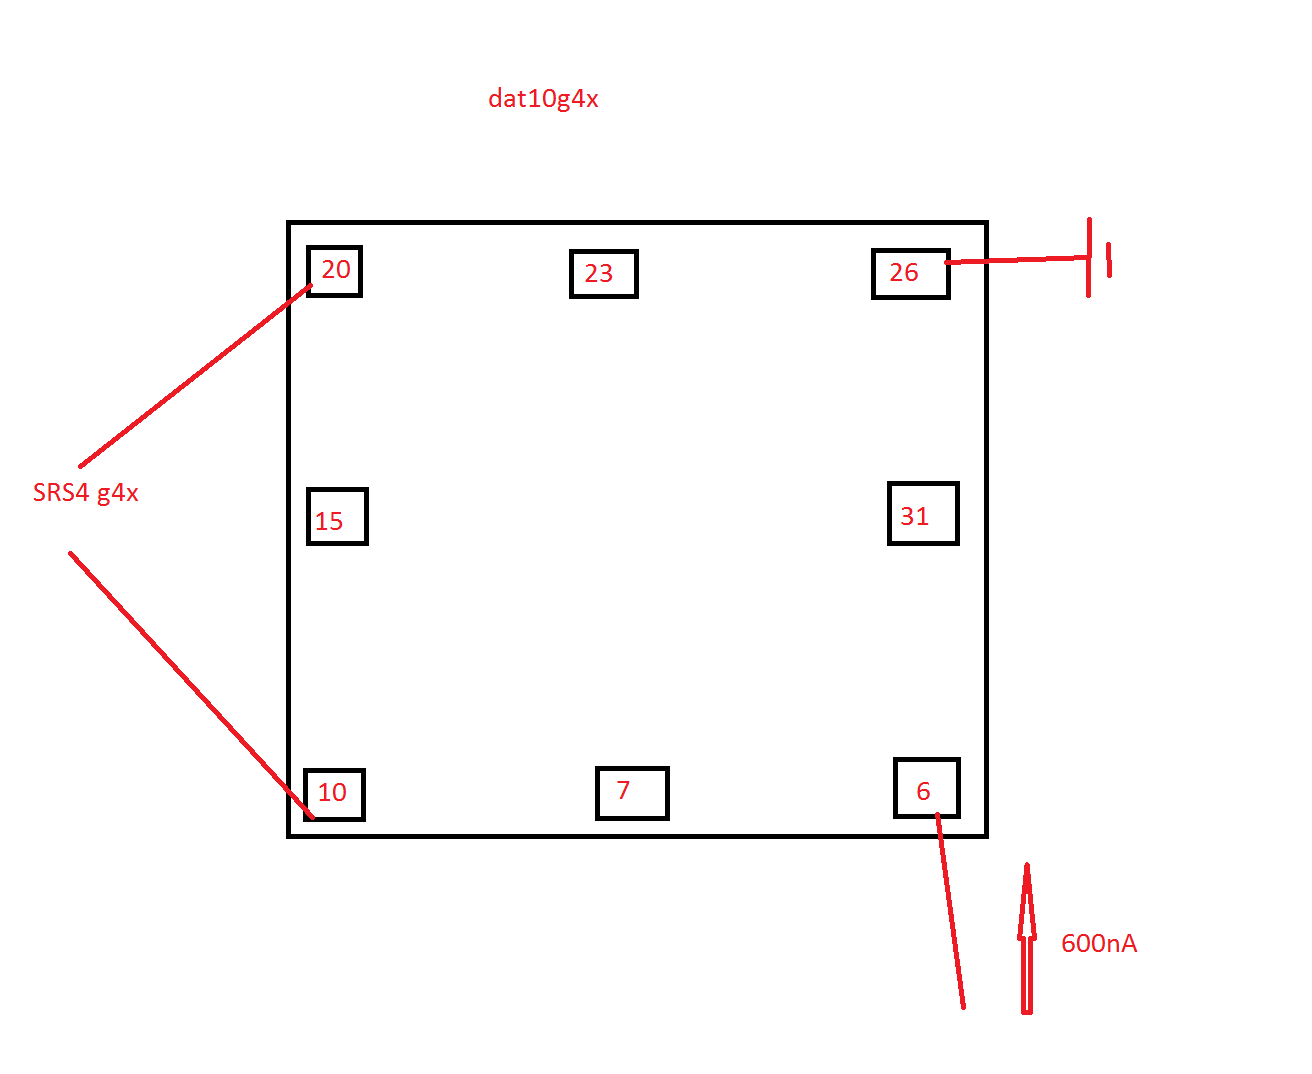

In [37]:
fig_dat10g4x = 'C:/Users/labuser/Desktop'
display(Image(filename=os.path.join(fig_dat10g4x,'configdat10g4x.png')))

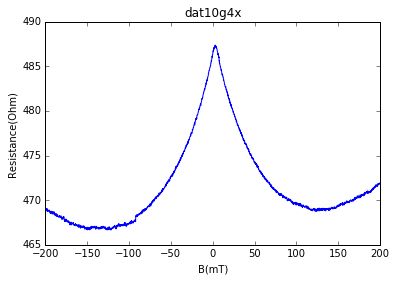

In [26]:
fig, ax = plt.subplots(1,1)
ax.plot(w4.x, (1)*w4.y/1000/600e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat10g4x')

# dat12

In [28]:
w5 = Waves('dat12g4x.ibw') 
w6 = Waves('dat12g1x.ibw') 
w7 = Waves('dat12g5x.ibw') 


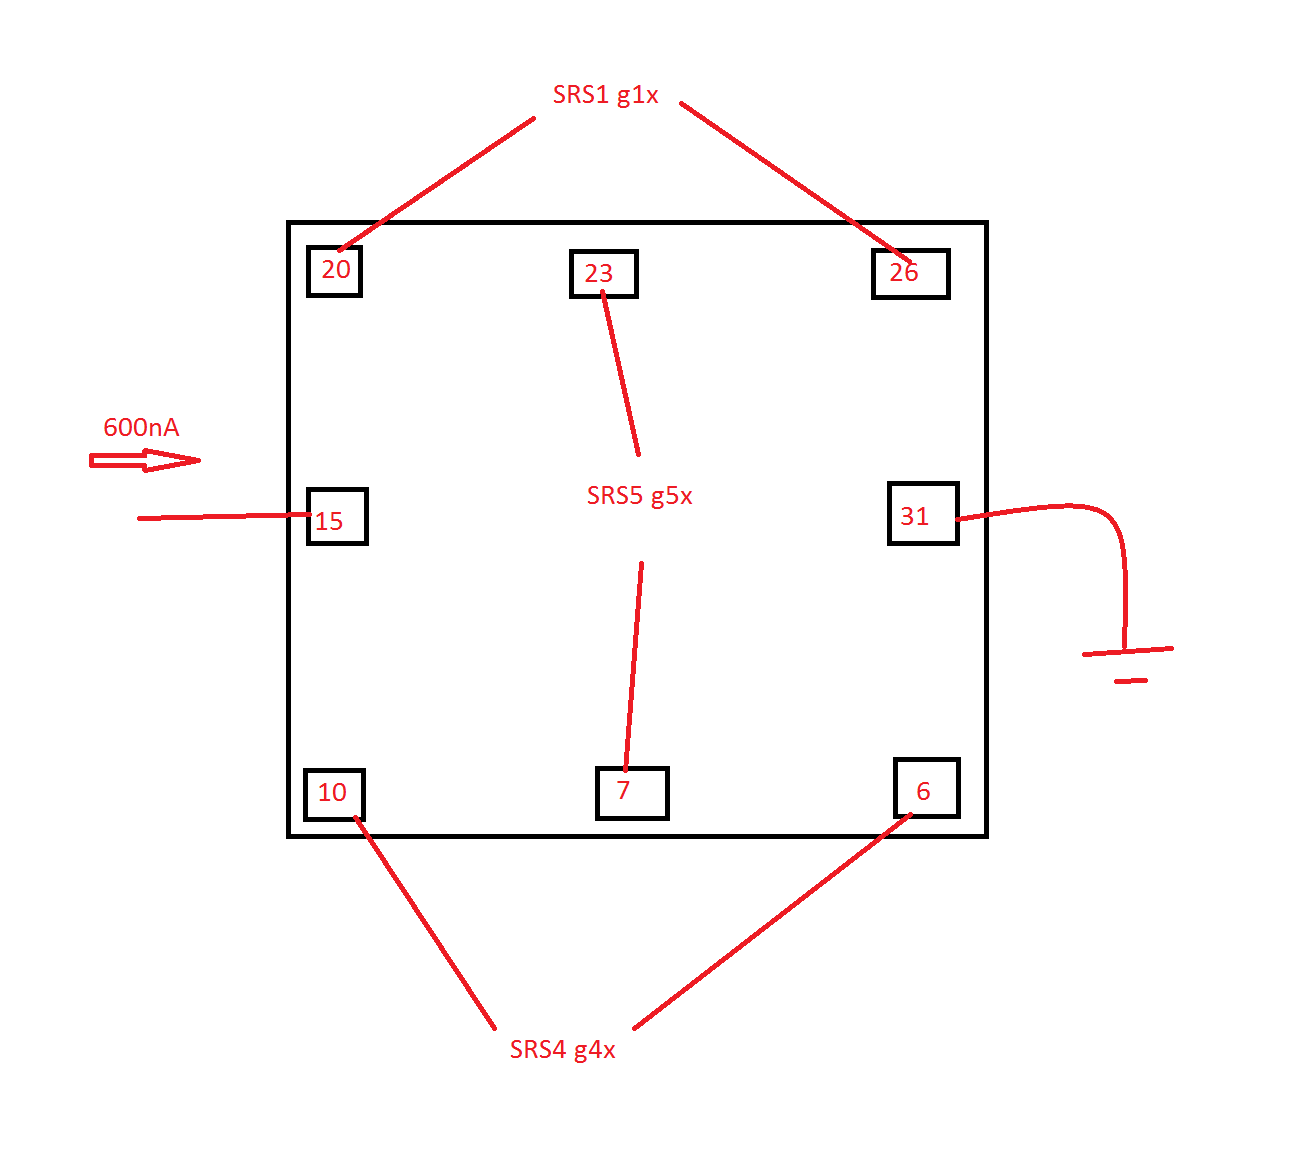

In [29]:
fig_dat12g4x = 'C:/Users/labuser/Desktop'
display(Image(filename=os.path.join(fig_dat12g4x,'configdat12.png')))

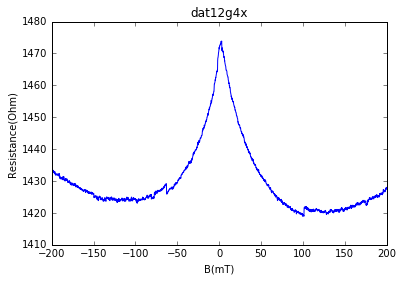

In [30]:
fig, ax = plt.subplots(1,1)
ax.plot(w5.x, (1)*w5.y/1000/600e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat12g4x')

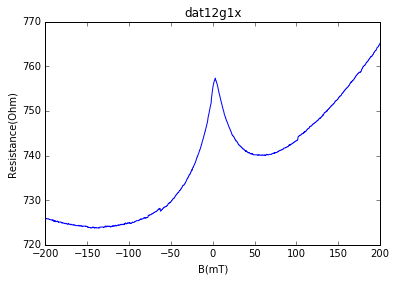

In [32]:
fig, ax = plt.subplots(1,1)
ax.plot(w6.x, (-1)*w6.y/1000/600e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat12g1x')

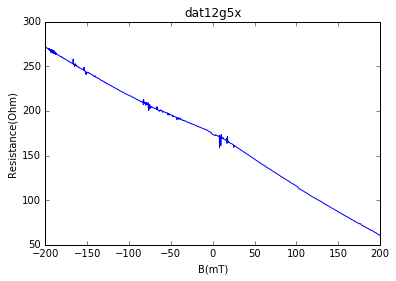

In [33]:
fig, ax = plt.subplots(1,1)
ax.plot(w7.x, (-1)*w7.y/1000/600e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat12g5x')

# check homogeniety of Vxy

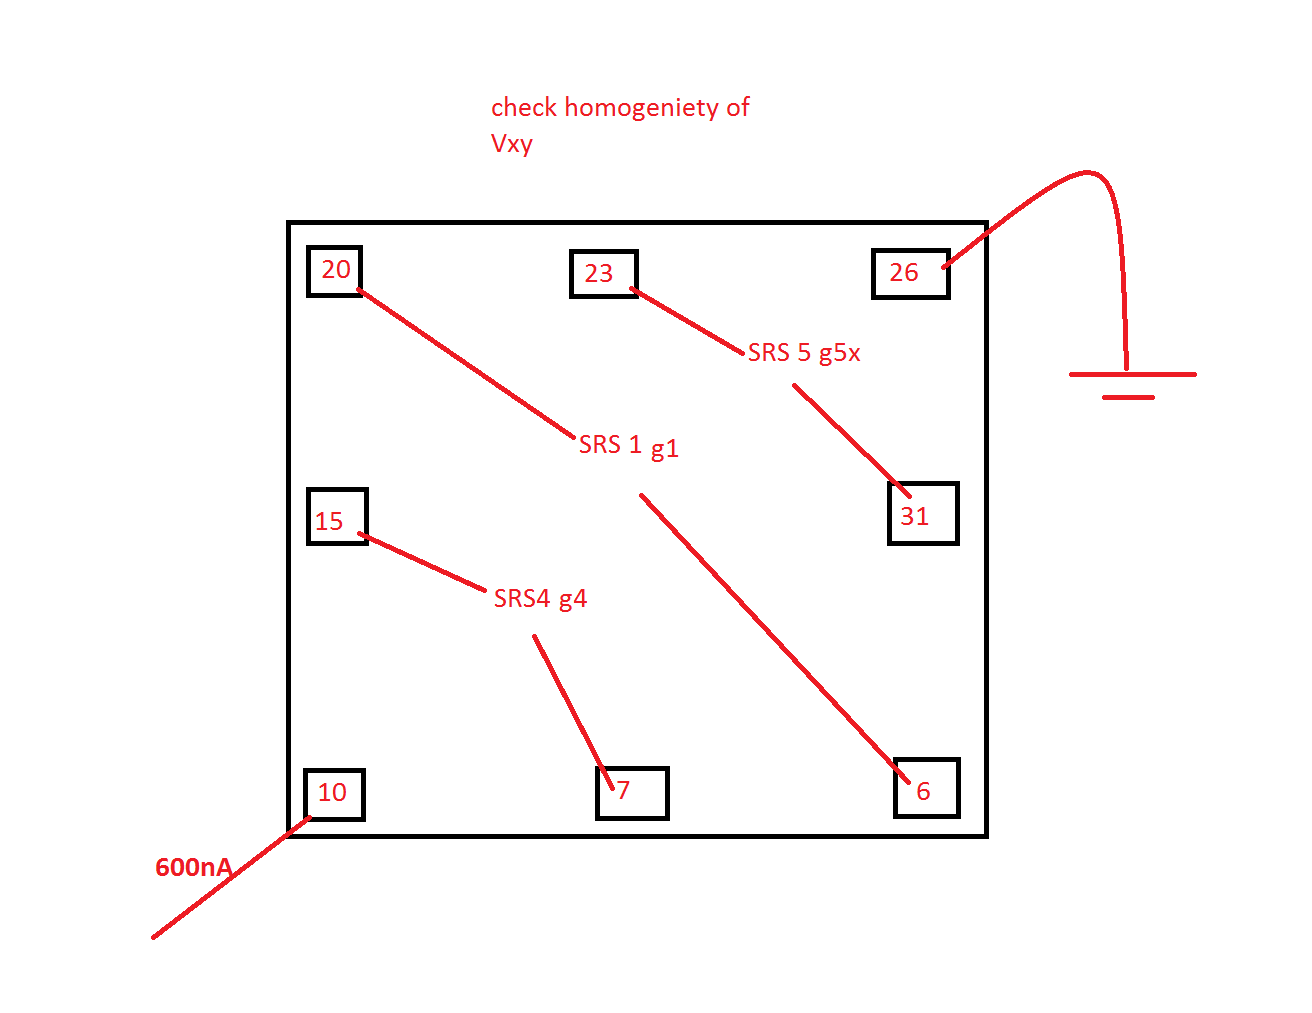

In [39]:
fig_dat14 = 'C:/Users/labuser/Desktop'
display(Image(filename=os.path.join(fig_dat14,'confighomogeniety1.png')))

In [40]:
dat14g4x = Waves('dat14g4x.ibw') 
dat14g1x = Waves('dat14g1x.ibw') 
dat14g5x = Waves('dat14g5x.ibw')

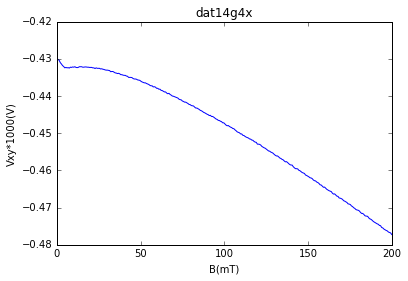

In [42]:
fig, ax = plt.subplots(1,1)
ax.plot(dat14g4x.x, (1)*dat14g4x.y)

plt.ylabel('Vxy*1000(V)')
plt.xlabel('B(mT)')
plt.title('dat14g4x')

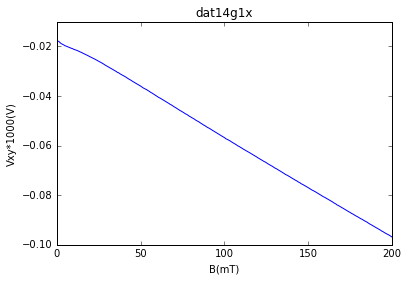

In [43]:
fig, ax = plt.subplots(1,1)
ax.plot(dat14g1x.x, (1)*dat14g1x.y)

plt.ylabel('Vxy*1000(V)')
plt.xlabel('B(mT)')
plt.title('dat14g1x')

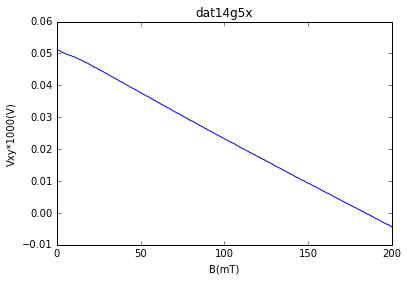

In [44]:
fig, ax = plt.subplots(1,1)
ax.plot(dat14g5x.x, (1)*dat14g5x.y)

plt.ylabel('Vxy*1000(V)')
plt.xlabel('B(mT)')
plt.title('dat14g5x')

# dat16

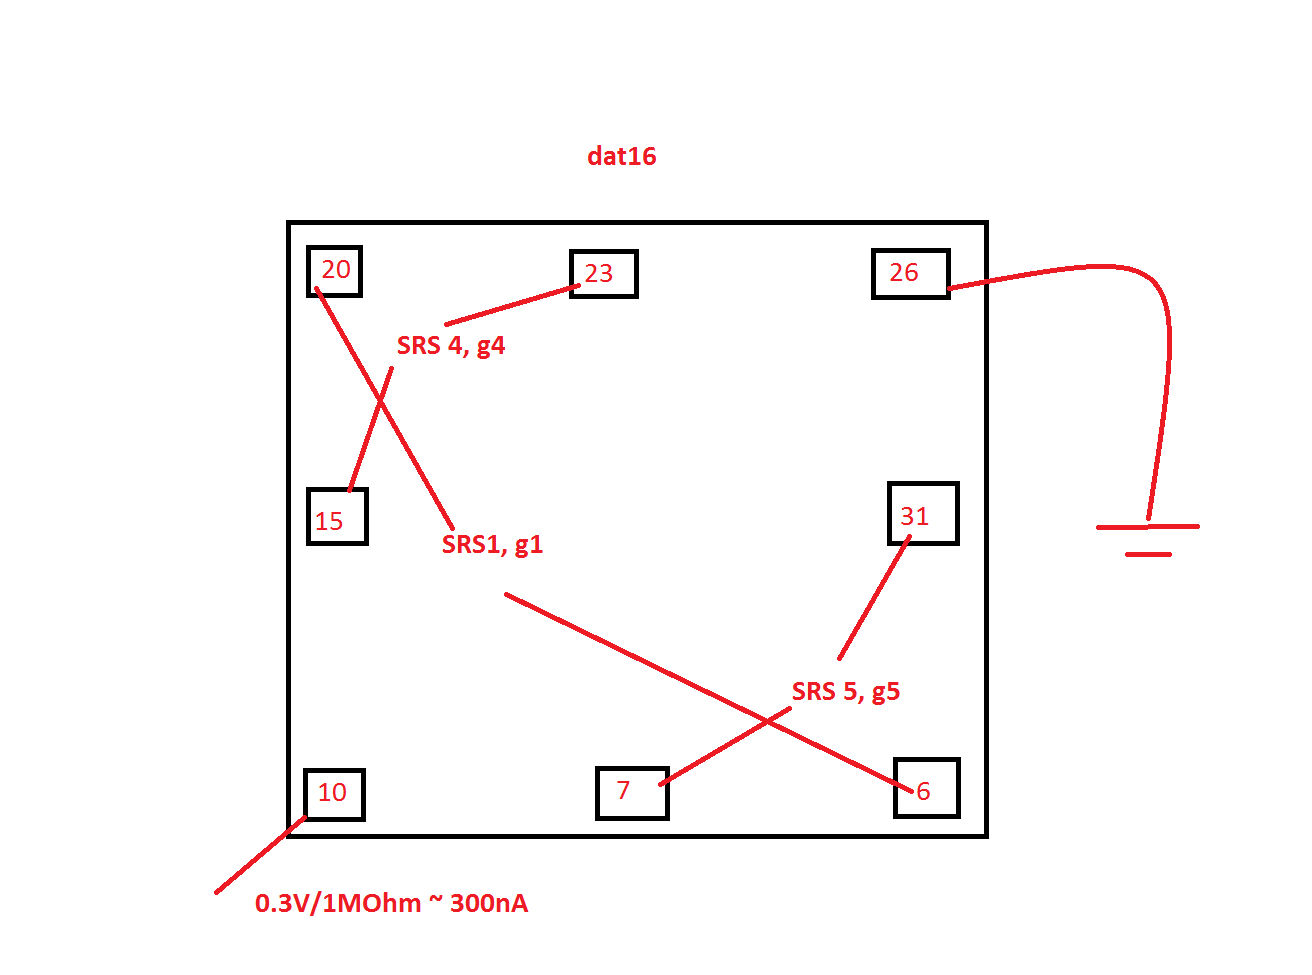

In [45]:
fig_dat16 = 'C:/Users/labuser/Desktop'
display(Image(filename=os.path.join(fig_dat16,'configdat16.png')))

In [46]:
dat16g4x = Waves('dat16g4x.ibw') 
dat16g1x = Waves('dat16g1x.ibw') 
dat16g5x = Waves('dat16g5x.ibw')

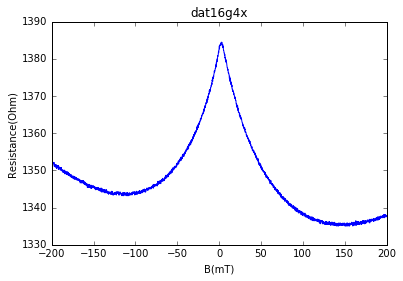

In [47]:
fig, ax = plt.subplots(1,1)
ax.plot(dat16g4x.x, (1)*dat16g4x.y/1000/300e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat16g4x')

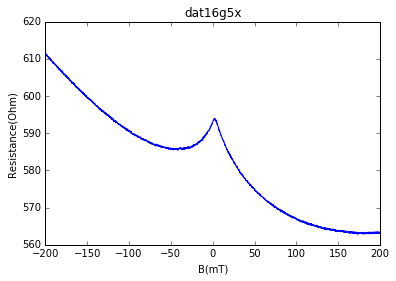

In [49]:
fig, ax = plt.subplots(1,1)
ax.plot(dat16g5x.x, (1)*dat16g5x.y/1000/300e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat16g5x')

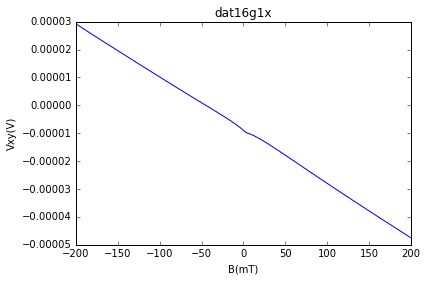

In [50]:
fig, ax = plt.subplots(1,1)
ax.plot(dat16g1x.x, (1)*dat16g1x.y/1000)

plt.ylabel('Vxy(V)')
plt.xlabel('B(mT)')
plt.title('dat16g1x')

# -500mT to 500mT scanning

In [51]:
dat26g4x = Waves('dat26g4x.ibw') 
dat26g1x = Waves('dat26g1x.ibw') 
dat26g5x = Waves('dat26g5x.ibw')

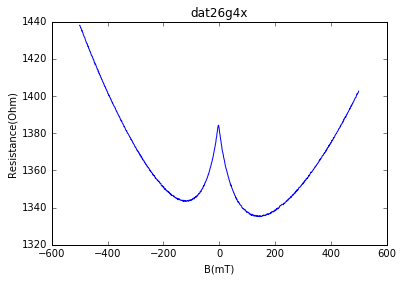

In [52]:
fig, ax = plt.subplots(1,1)
ax.plot(dat26g4x.x, (1)*dat26g4x.y/1000/300e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat26g4x')

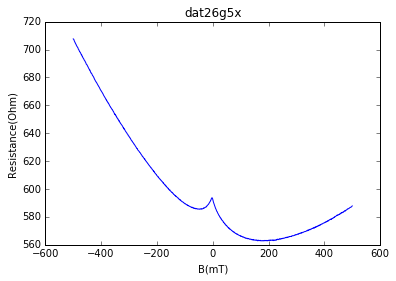

In [53]:
fig, ax = plt.subplots(1,1)
ax.plot(dat26g5x.x, (1)*dat26g5x.y/1000/300e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat26g5x')

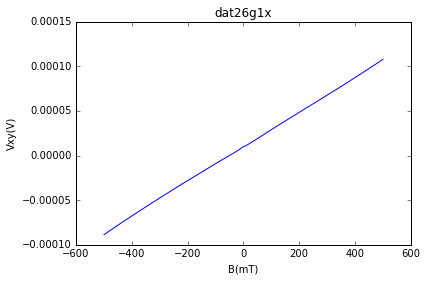

In [54]:
fig, ax = plt.subplots(1,1)
ax.plot(dat26g1x.x, (1)*dat26g1x.y/1000)

plt.ylabel('Vxy(V)')
plt.xlabel('B(mT)')
plt.title('dat26g1x')

# 500mT to  -500mT scanning

In [55]:
dat27g4x = Waves('dat27g4x.ibw') 
dat27g1x = Waves('dat27g1x.ibw') 
dat27g5x = Waves('dat27g5x.ibw')




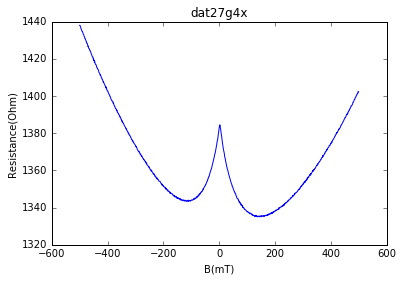

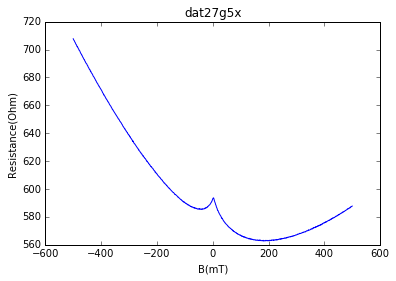

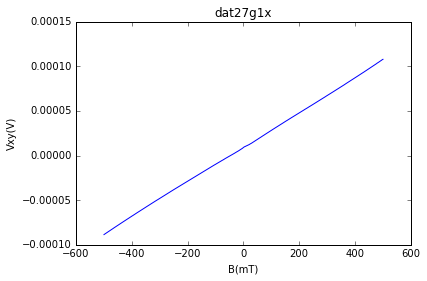

In [56]:
fig, ax = plt.subplots(1,1)
ax.plot(dat27g4x.x, (1)*dat27g4x.y/1000/300e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat27g4x')





fig, ax = plt.subplots(1,1)
ax.plot(dat27g5x.x, (1)*dat27g5x.y/1000/300e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat27g5x')



fig, ax = plt.subplots(1,1)
ax.plot(dat27g1x.x, (1)*dat27g1x.y/1000)

plt.ylabel('Vxy(V)')
plt.xlabel('B(mT)')
plt.title('dat27g1x')





# -200mT to 200mT


In [57]:
dat28g4x = Waves('dat28g4x.ibw') 
dat28g1x = Waves('dat28g1x.ibw') 
dat28g5x = Waves('dat28g5x.ibw')

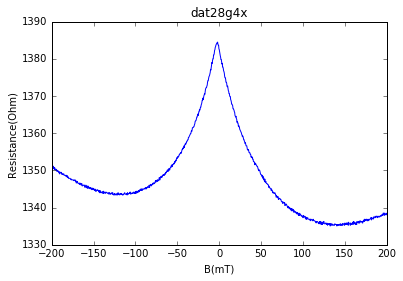

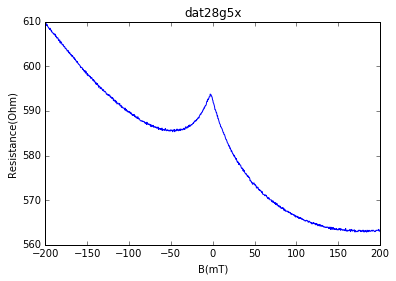

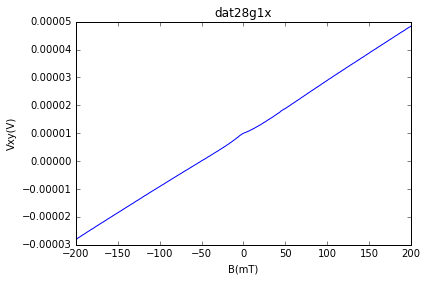

In [58]:
fig, ax = plt.subplots(1,1)
ax.plot(dat28g4x.x, (1)*dat28g4x.y/1000/300e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat28g4x')





fig, ax = plt.subplots(1,1)
ax.plot(dat28g5x.x, (1)*dat28g5x.y/1000/300e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat28g5x')



fig, ax = plt.subplots(1,1)
ax.plot(dat28g1x.x, (1)*dat28g1x.y/1000)

plt.ylabel('Vxy(V)')
plt.xlabel('B(mT)')
plt.title('dat28g1x')

# 200mT to -200mT

In [59]:
dat29g4x = Waves('dat29g4x.ibw') 
dat29g1x = Waves('dat29g1x.ibw') 
dat29g5x = Waves('dat29g5x.ibw')

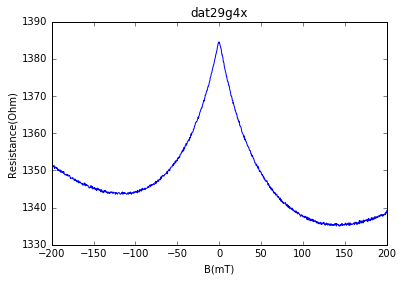

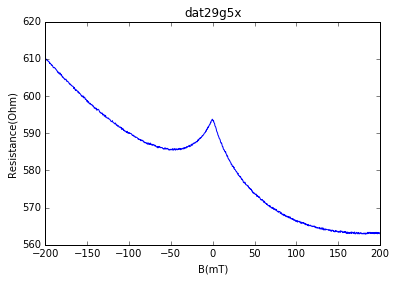

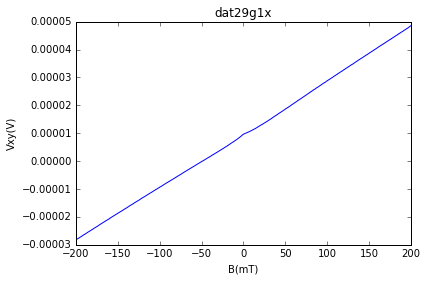

In [60]:
fig, ax = plt.subplots(1,1)
ax.plot(dat29g4x.x, (1)*dat29g4x.y/1000/300e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat29g4x')





fig, ax = plt.subplots(1,1)
ax.plot(dat29g5x.x, (1)*dat29g5x.y/1000/300e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat29g5x')



fig, ax = plt.subplots(1,1)
ax.plot(dat29g1x.x, (1)*dat29g1x.y/1000)

plt.ylabel('Vxy(V)')
plt.xlabel('B(mT)')
plt.title('dat29g1x')

# -100mT to 100mT

In [61]:
dat30g4x = Waves('dat30g4x.ibw') 
dat30g1x = Waves('dat30g1x.ibw') 
dat30g5x = Waves('dat30g5x.ibw')

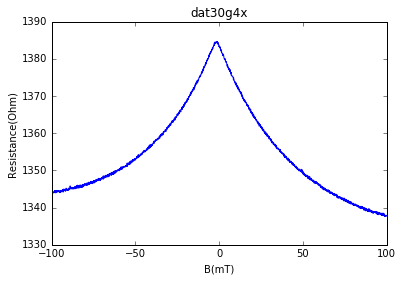

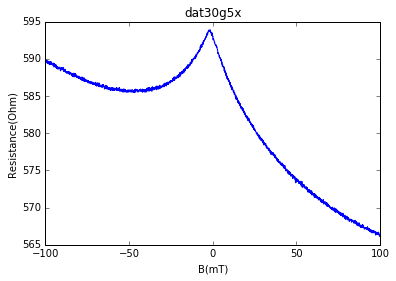

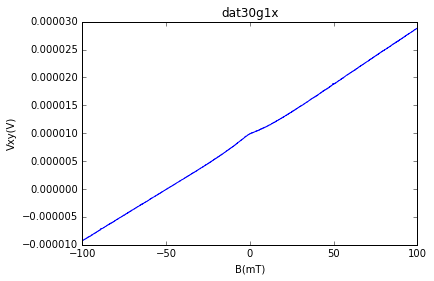

In [65]:
fig, ax = plt.subplots(1,1)
ax.plot(dat30g4x.x, (1)*dat30g4x.y/1000/300e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat30g4x')





fig, ax = plt.subplots(1,1)
ax.plot(dat30g5x.x, (1)*dat30g5x.y/1000/300e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat30g5x')



fig, ax = plt.subplots(1,1)
ax.plot(dat30g1x.x, (1)*dat30g1x.y/1000)

plt.ylabel('Vxy(V)')
plt.xlabel('B(mT)')
plt.title('dat30g1x')

# 100mT to -100mT

In [66]:
dat31g4x = Waves('dat31g4x.ibw') 
dat31g1x = Waves('dat31g1x.ibw') 
dat31g5x = Waves('dat31g5x.ibw')

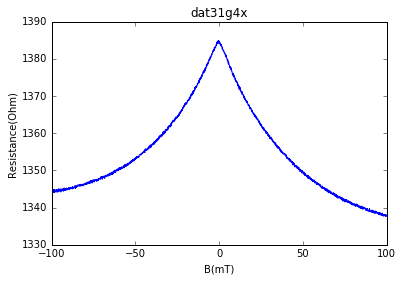

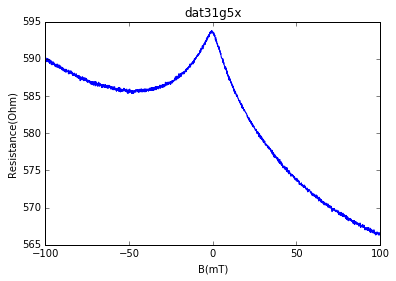

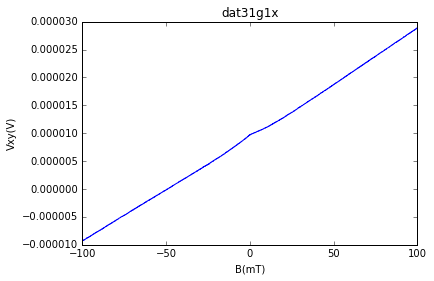

In [67]:
fig, ax = plt.subplots(1,1)
ax.plot(dat31g4x.x, (1)*dat31g4x.y/1000/300e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat31g4x')





fig, ax = plt.subplots(1,1)
ax.plot(dat31g5x.x, (1)*dat31g5x.y/1000/300e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat31g5x')



fig, ax = plt.subplots(1,1)
ax.plot(dat31g1x.x, (1)*dat31g1x.y/1000)

plt.ylabel('Vxy(V)')
plt.xlabel('B(mT)')
plt.title('dat31g1x')

# dat17

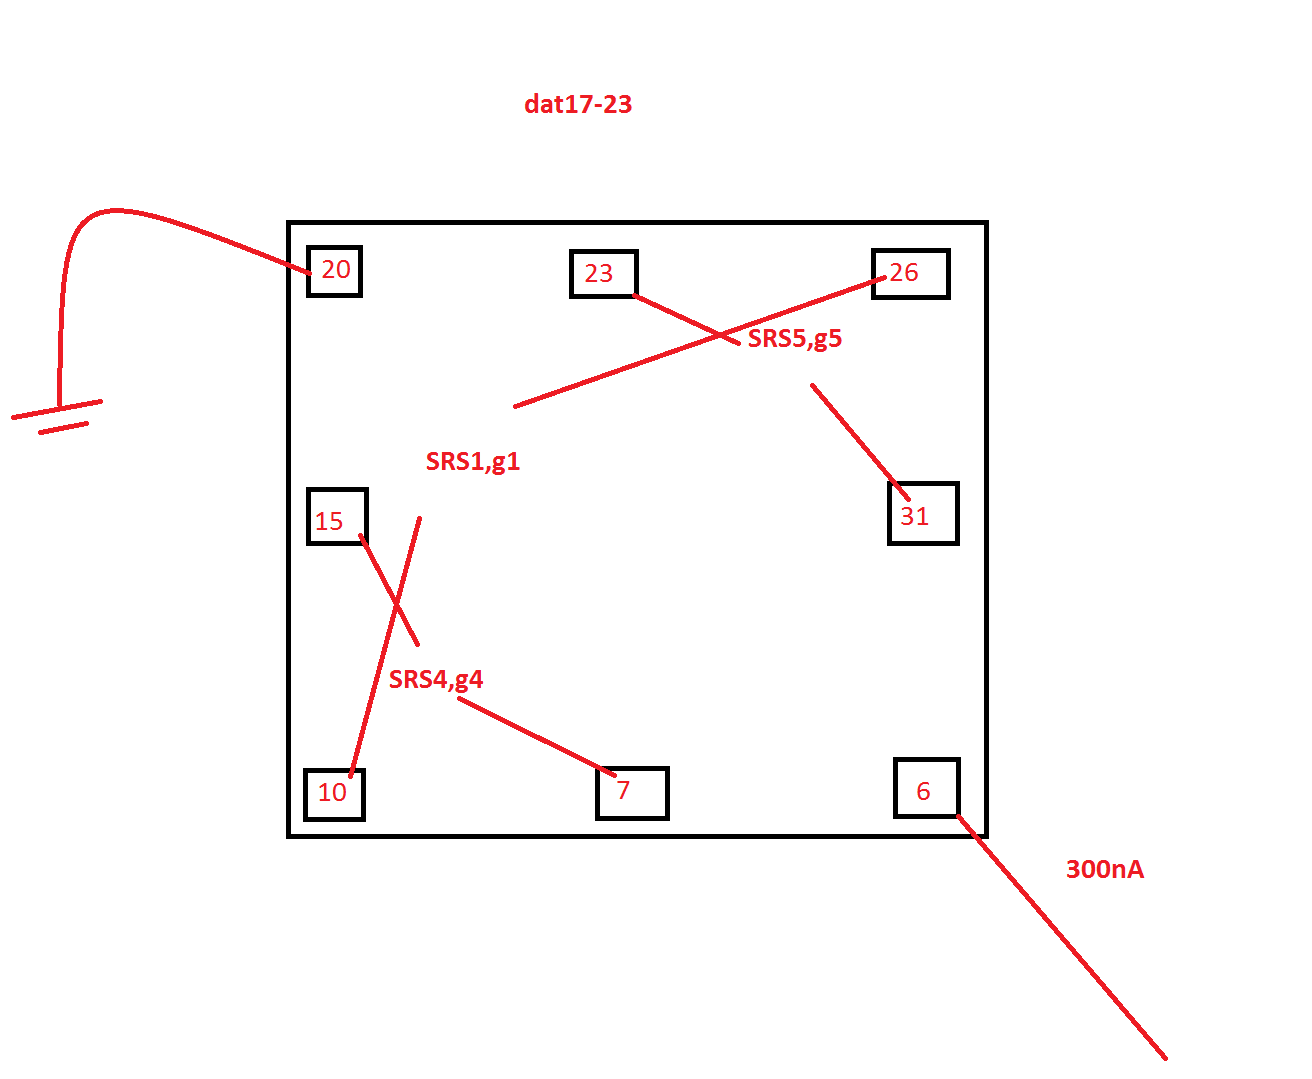

In [69]:
fig_dat17 = 'C:/Users/labuser/Desktop'
display(Image(filename=os.path.join(fig_dat17,'config17t23.png')))

In [70]:
dat17g4x = Waves('dat17g4x.ibw') 
dat17g1x = Waves('dat17g1x.ibw') 
dat17g5x = Waves('dat17g5x.ibw')

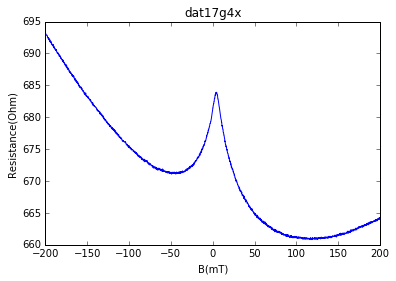

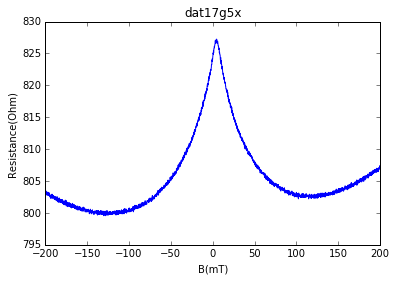

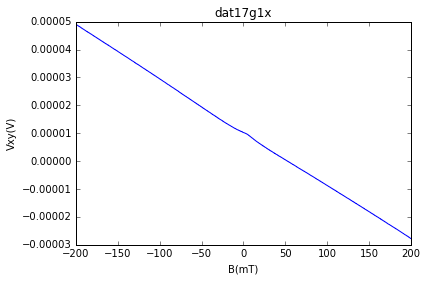

In [72]:
fig, ax = plt.subplots(1,1)
ax.plot(dat17g4x.x, (-1)*dat17g4x.y/1000/300e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat17g4x')





fig, ax = plt.subplots(1,1)
ax.plot(dat17g5x.x, (-1)*dat17g5x.y/1000/300e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat17g5x')



fig, ax = plt.subplots(1,1)
ax.plot(dat17g1x.x, (1)*dat17g1x.y/1000)

plt.ylabel('Vxy(V)')
plt.xlabel('B(mT)')
plt.title('dat17g1x')

# -500mT to 500mT

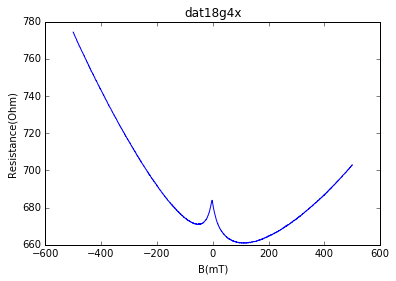

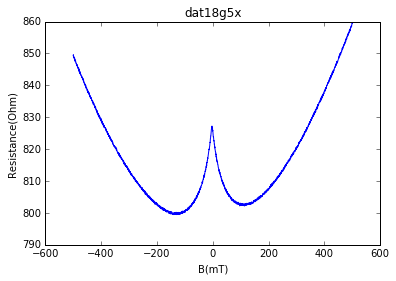

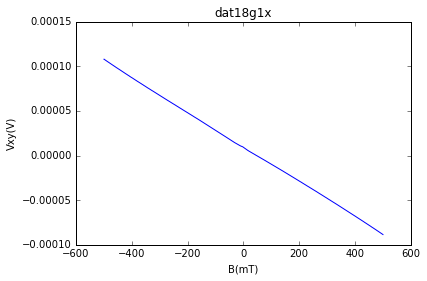

In [73]:
dat18g4x = Waves('dat18g4x.ibw') 
dat18g1x = Waves('dat18g1x.ibw') 
dat18g5x = Waves('dat18g5x.ibw')


fig, ax = plt.subplots(1,1)
ax.plot(dat18g4x.x, (-1)*dat18g4x.y/1000/300e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat18g4x')





fig, ax = plt.subplots(1,1)
ax.plot(dat18g5x.x, (-1)*dat18g5x.y/1000/300e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat18g5x')



fig, ax = plt.subplots(1,1)
ax.plot(dat18g1x.x, (1)*dat18g1x.y/1000)

plt.ylabel('Vxy(V)')
plt.xlabel('B(mT)')
plt.title('dat18g1x')




# 500mT to -500mT

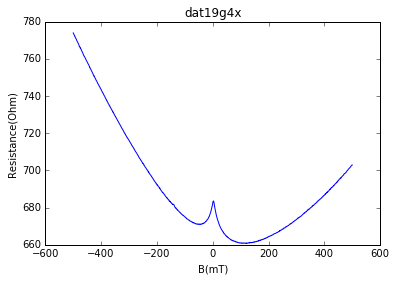

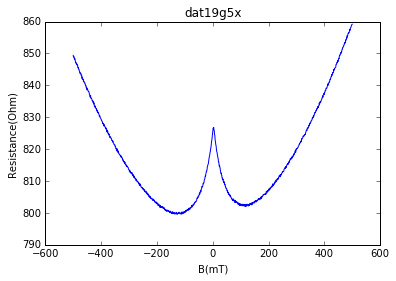

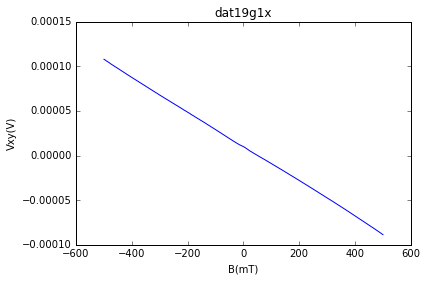

In [74]:
dat19g4x = Waves('dat19g4x.ibw') 
dat19g1x = Waves('dat19g1x.ibw') 
dat19g5x = Waves('dat19g5x.ibw')


fig, ax = plt.subplots(1,1)
ax.plot(dat19g4x.x, (-1)*dat19g4x.y/1000/300e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat19g4x')





fig, ax = plt.subplots(1,1)
ax.plot(dat19g5x.x, (-1)*dat19g5x.y/1000/300e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat19g5x')



fig, ax = plt.subplots(1,1)
ax.plot(dat19g1x.x, (1)*dat19g1x.y/1000)

plt.ylabel('Vxy(V)')
plt.xlabel('B(mT)')
plt.title('dat19g1x')

# -200mT to 200mT

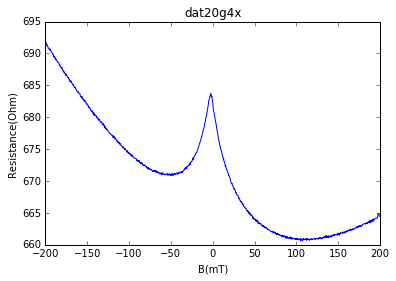

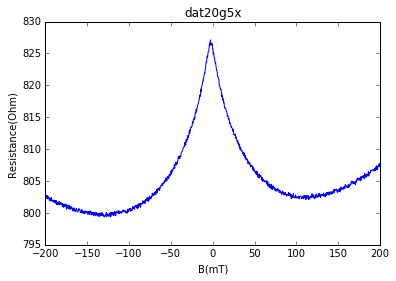

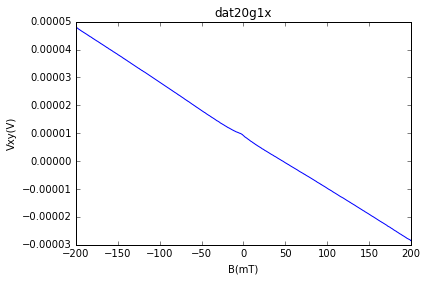

In [76]:
dat20g4x = Waves('dat20g4x.ibw') 
dat20g1x = Waves('dat20g1x.ibw') 
dat20g5x = Waves('dat20g5x.ibw')


fig, ax = plt.subplots(1,1)
ax.plot(dat20g4x.x, (1)*dat20g4x.y/1000/300e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat20g4x')





fig, ax = plt.subplots(1,1)
ax.plot(dat20g5x.x, (1)*dat20g5x.y/1000/300e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat20g5x')



fig, ax = plt.subplots(1,1)
ax.plot(dat20g1x.x, (1)*dat20g1x.y/1000)

plt.ylabel('Vxy(V)')
plt.xlabel('B(mT)')
plt.title('dat20g1x')

# 200mT to -200mT

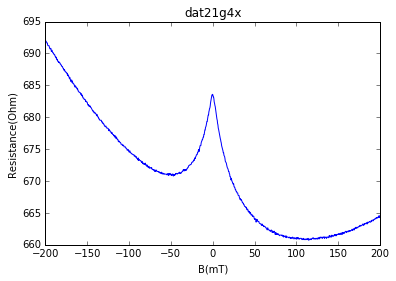

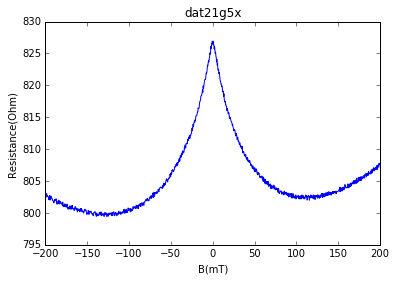

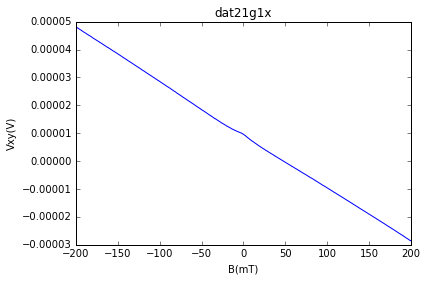

In [77]:
dat21g4x = Waves('dat21g4x.ibw') 
dat21g1x = Waves('dat21g1x.ibw') 
dat21g5x = Waves('dat21g5x.ibw')


fig, ax = plt.subplots(1,1)
ax.plot(dat21g4x.x, (1)*dat21g4x.y/1000/300e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat21g4x')





fig, ax = plt.subplots(1,1)
ax.plot(dat21g5x.x, (1)*dat21g5x.y/1000/300e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat21g5x')



fig, ax = plt.subplots(1,1)
ax.plot(dat21g1x.x, (1)*dat21g1x.y/1000)

plt.ylabel('Vxy(V)')
plt.xlabel('B(mT)')
plt.title('dat21g1x')

# -100mT to 100mT

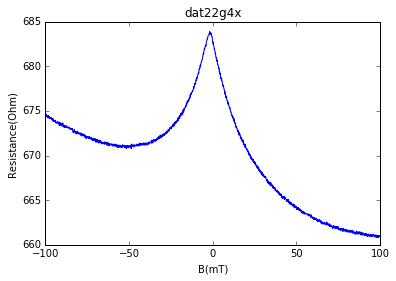

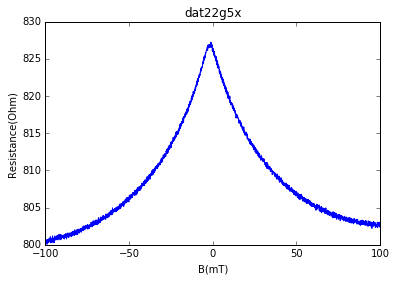

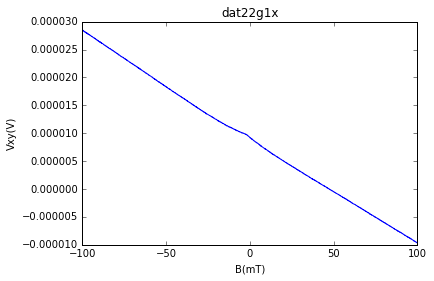

In [78]:
dat22g4x = Waves('dat22g4x.ibw') 
dat22g1x = Waves('dat22g1x.ibw') 
dat22g5x = Waves('dat22g5x.ibw')


fig, ax = plt.subplots(1,1)
ax.plot(dat22g4x.x, (1)*dat22g4x.y/1000/300e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat22g4x')





fig, ax = plt.subplots(1,1)
ax.plot(dat22g5x.x, (1)*dat22g5x.y/1000/300e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat22g5x')



fig, ax = plt.subplots(1,1)
ax.plot(dat22g1x.x, (1)*dat22g1x.y/1000)

plt.ylabel('Vxy(V)')
plt.xlabel('B(mT)')
plt.title('dat22g1x')

# 100mT to -100mT

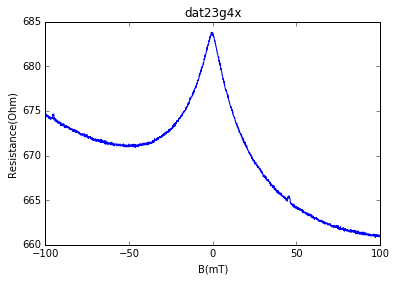

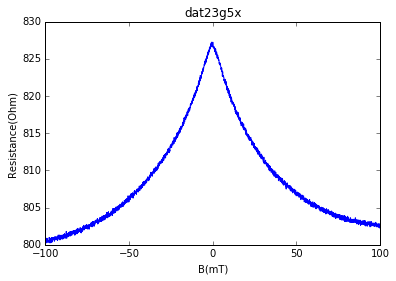

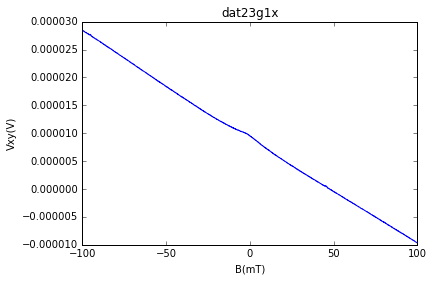

In [79]:
dat23g4x = Waves('dat23g4x.ibw') 
dat23g1x = Waves('dat23g1x.ibw') 
dat23g5x = Waves('dat23g5x.ibw')


fig, ax = plt.subplots(1,1)
ax.plot(dat23g4x.x, (1)*dat23g4x.y/1000/300e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat23g4x')





fig, ax = plt.subplots(1,1)
ax.plot(dat23g5x.x, (1)*dat23g5x.y/1000/300e-9)

plt.ylabel('Resistance(Ohm)')
plt.xlabel('B(mT)')
plt.title('dat23g5x')



fig, ax = plt.subplots(1,1)
ax.plot(dat23g1x.x, (1)*dat23g1x.y/1000)

plt.ylabel('Vxy(V)')
plt.xlabel('B(mT)')
plt.title('dat23g1x')

# check Vxy inhomogeniety for this configuration

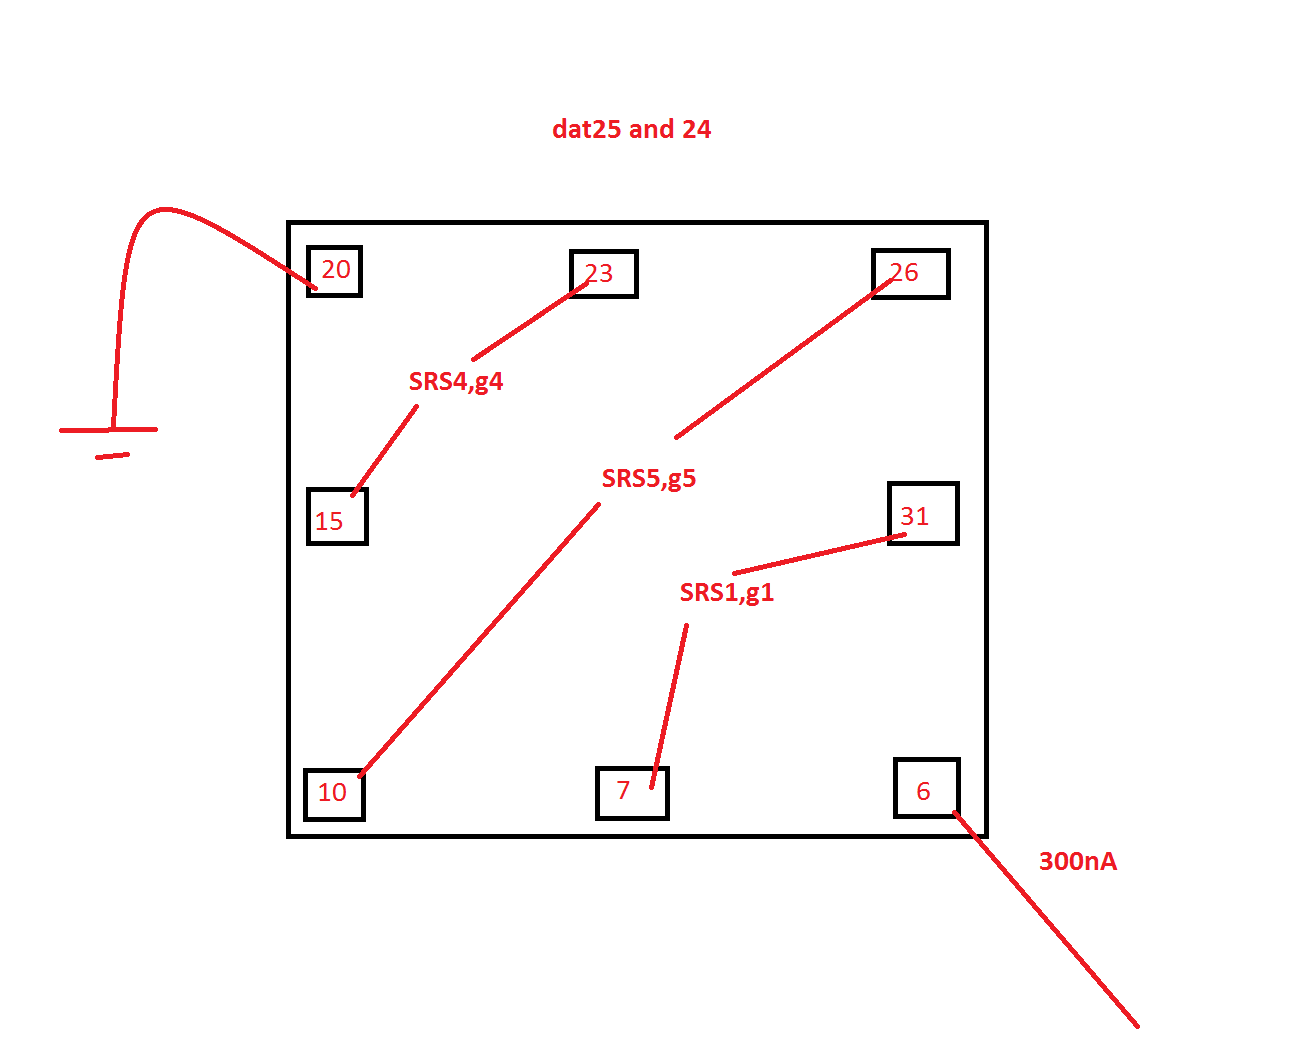

In [80]:
figs= 'C:/Users/labuser/Desktop'
display(Image(filename=os.path.join(figs,'configdat25.png')))

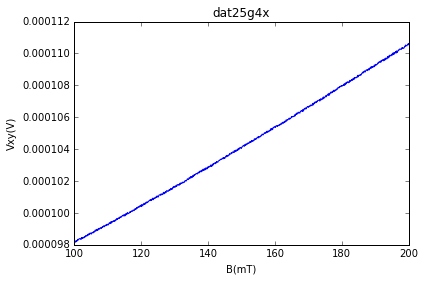

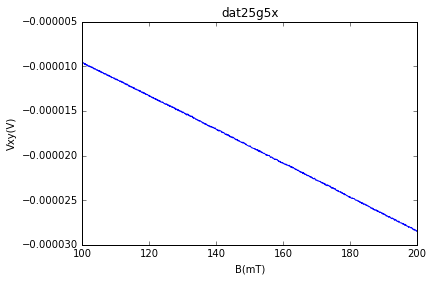

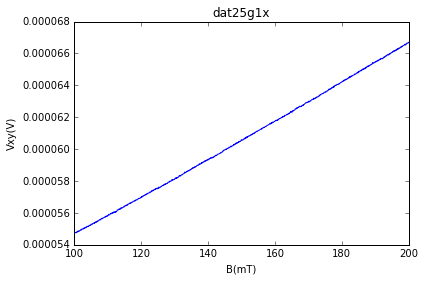

In [81]:
dat25g4x = Waves('dat25g4x.ibw') 
dat25g1x = Waves('dat25g1x.ibw') 
dat25g5x = Waves('dat25g5x.ibw')


fig, ax = plt.subplots(1,1)
ax.plot(dat25g4x.x, (1)*dat25g4x.y/1000)

plt.ylabel('Vxy(V)')
plt.xlabel('B(mT)')
plt.title('dat25g4x')





fig, ax = plt.subplots(1,1)
ax.plot(dat25g5x.x, (1)*dat25g5x.y/1000)

plt.ylabel('Vxy(V)')
plt.xlabel('B(mT)')
plt.title('dat25g5x')



fig, ax = plt.subplots(1,1)
ax.plot(dat25g1x.x, (1)*dat25g1x.y/1000)

plt.ylabel('Vxy(V)')
plt.xlabel('B(mT)')
plt.title('dat25g1x')